In [6]:

from pathlib import Path

# Base = src directory (where this notebook/script lives)
BASE_DIR = Path.cwd()          # if running from src/
DATA_DIR = BASE_DIR / "data"

HUGCDN_DIR = DATA_DIR / "HuGCDN2014-OXI"

print("Base dir:", BASE_DIR)
print("HuGCDN dir:", HUGCDN_DIR)


Base dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src
HuGCDN dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\HuGCDN2014-OXI


Base dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src
Data dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data
HuGCDN dir: d:\school\uni\sem 5\MLDL\TinyML UAS\src\data\HuGCDN2014-OXI
Loaded C1: X=(312, 200, 2), y=(312,)
Loaded C10: X=(448, 200, 2), y=(448,)
Loaded C11: X=(416, 200, 2), y=(416,)
Loaded C12: X=(441, 200, 2), y=(441,)
Loaded C13: X=(452, 200, 2), y=(452,)
Loaded C14: X=(443, 200, 2), y=(443,)
Loaded C15: X=(446, 200, 2), y=(446,)
Loaded C16: X=(452, 200, 2), y=(452,)
Loaded C17: X=(466, 200, 2), y=(466,)
Loaded C18: X=(451, 200, 2), y=(451,)
Loaded C19: X=(440, 200, 2), y=(440,)
Loaded C2: X=(434, 200, 2), y=(434,)
Loaded C20: X=(443, 200, 2), y=(443,)
Loaded C21: X=(447, 200, 2), y=(447,)
Loaded C22: X=(445, 200, 2), y=(445,)
Loaded C23: X=(449, 200, 2), y=(449,)
Loaded C24: X=(444, 200, 2), y=(444,)
Loaded C25: X=(438, 200, 2), y=(438,)
Loaded C26: X=(424, 200, 2), y=(424,)
Loaded C27: X=(432, 200, 2), y=(432,)
Loaded C28: X=(451, 200, 2), y=(451,)
Loaded C29: X=(430, 200, 2)

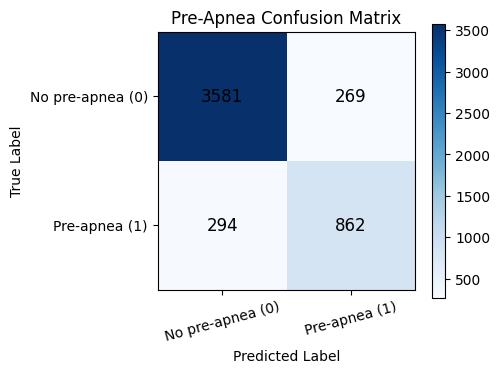

In [7]:
"""
pre_apnea_hugcdn.py

Pre-apnea prediction using HuGCDN2014-OXI (RR + SpO2):
- Loads .mat files (RR, SAT, LABELS)
- Builds per-epoch features (T x 2)
- Converts apnea labels to pre-apnea labels (apnea in next K minutes)
- Trains a small 1D CNN
- Evaluates on test set (loss, accuracy, confusion matrix, report)
"""

import os

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import tensorflow as tf
from tensorflow.keras import layers, models


# ----------------------------------------------------------------------
# 1. Paths and basic config
# ----------------------------------------------------------------------

DATA_DIR = BASE_DIR / "data"
HUGCDN_DIR = DATA_DIR / "HuGCDN2014-OXI"

# time steps per epoch after resampling (you can tweak this)
T_STEPS = 200
# pre-apnea horizon in epochs (minutes) -> 1 means "apnea in the next 1 minute"
PRE_APNEA_HORIZON = 1
RANDOM_STATE = 42


# ----------------------------------------------------------------------
# 2. Helpers for loading HuGCDN2014-OXI
# ----------------------------------------------------------------------

def load_labels(path: Path) -> np.ndarray:
    """
    Load per-minute labels from LABELS/*.mat.
    Uses salida_man_1m if available, else salida_man, else first non-meta key.
    Returns 1D int array of shape (n_epochs,)
    """
    d = loadmat(path)
    if "salida_man_1m" in d:
        raw = d["salida_man_1m"]
    elif "salida_man" in d:
        raw = d["salida_man"]
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    labels = np.ravel(raw).astype(int)
    return labels


def extract_epoch_series(raw) -> list:
    """
    Convert MATLAB cell / numeric array into a list of 1D float arrays,
    one per epoch.
    """
    arr = np.array(raw)

    # cell array (dtype=object): each cell is an epoch
    if arr.dtype == object:
        epochs = []
        for x in arr.ravel():
            x = np.array(x).astype(float).ravel()
            if x.size > 0:
                epochs.append(x)
        return epochs

    # numeric array
    arr = np.squeeze(arr)
    if arr.ndim == 1:
        return [arr.astype(float)]
    else:
        return [arr[i, :].astype(float).ravel() for i in range(arr.shape[0])]


def load_rr_epochs(path: Path) -> list:
    d = loadmat(path)
    for name in ["rr", "RR", "rr_1m", "RR_1m"]:
        if name in d:
            raw = d[name]
            break
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    return extract_epoch_series(raw)


def load_sat_epochs(path: Path) -> list:
    d = loadmat(path)
    for name in ["sat", "Sat", "SaO2", "satO2", "SaO2_1m"]:
        if name in d:
            raw = d[name]
            break
    else:
        keys = [k for k in d.keys() if not k.startswith("__")]
        raw = d[keys[0]]
    return extract_epoch_series(raw)


def resize_epoch(x: np.ndarray, target_len: int) -> np.ndarray:
    """
    Linearly resample a 1D array x to fixed length target_len.
    """
    x = np.asarray(x, dtype=float).ravel()
    if x.size == 0:
        return np.zeros(target_len, dtype=float)
    if x.size == target_len:
        return x
    old_idx = np.linspace(0.0, 1.0, num=x.size)
    new_idx = np.linspace(0.0, 1.0, num=target_len)
    return np.interp(new_idx, old_idx, x)


def load_hugcdn_subject(subject_id: str, T: int = 200):
    """
    Load one HuGCDN subject as fixed-length epochs.

    Returns
    -------
    X  : np.ndarray  (n_epochs, T, 2)  -> [RR_z, SAT_z]
    y  : np.ndarray  (n_epochs,)       -> 0/1 apnea labels for that minute
    """
    label_path = HUGCDN_DIR / "LABELS" / f"{subject_id}.mat"
    rr_path = HUGCDN_DIR / "RR" / f"{subject_id}.mat"
    sat_path = HUGCDN_DIR / "SAT" / f"{subject_id}.mat"

    labels = load_labels(label_path)
    rr_ep = load_rr_epochs(rr_path)
    sat_ep = load_sat_epochs(sat_path)

    n_labels = len(labels)
    n_rr = len(rr_ep)
    n_sat = len(sat_ep)

    n_epochs = min(n_labels, n_rr, n_sat)
    if n_epochs == 0:
        raise ValueError("No usable epochs for subject %s" % subject_id)

    labels = labels[:n_epochs]
    rr_ep = rr_ep[:n_epochs]
    sat_ep = sat_ep[:n_epochs]

    # resample each epoch to length T
    rr_resampled = np.stack([resize_epoch(e, T) for e in rr_ep], axis=0)
    sat_resampled = np.stack([resize_epoch(e, T) for e in sat_ep], axis=0)

    # per-epoch z-normalisation
    def z_norm(ep):
        mu = ep.mean(axis=1, keepdims=True)
        sigma = ep.std(axis=1, keepdims=True) + 1e-6
        return (ep - mu) / sigma

    rr_z = z_norm(rr_resampled)
    sat_z = z_norm(sat_resampled)

    X = np.stack([rr_z, sat_z], axis=-1)
    y = labels.astype(int)

    return X, y


def load_all_hugcdn(T: int = 200):
    """
    Load all subjects in HuGCDN2014-OXI into one big array.

    Returns
    -------
    X           : (N, T, 2)
    y           : (N,)
    subject_idx : (N,) array of subject IDs (strings)
    """
    label_dir = HUGCDN_DIR / "LABELS"
    subject_ids = sorted(f.stem for f in label_dir.glob("*.mat"))

    X_list = []
    y_list = []
    subj_idx = []

    for sid in subject_ids:
        try:
            X_s, y_s = load_hugcdn_subject(sid, T=T)
            X_list.append(X_s)
            y_list.append(y_s)
            subj_idx.extend([sid] * len(y_s))
            print("Loaded %s: X=%s, y=%s" % (sid, X_s.shape, y_s.shape))
        except Exception as e:
            print("Skipping %s because of error: %s" % (sid, e))

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    subject_idx = np.array(subj_idx)

    print("Final dataset:")
    print("X:", X.shape, "y:", y.shape)
    return X, y, subject_idx


# ----------------------------------------------------------------------
# 3. Build pre-apnea labels
# ----------------------------------------------------------------------

def make_pre_apnea_labels(y, subject_idx, horizon=1):
    """
    For each epoch t (one minute), label 1 if ANY apnea occurs in
    epochs t+1 .. t+horizon within the same subject.
    Else 0.

    Parameters
    ----------
    y           : (N,) apnea labels (0/1 for that minute)
    subject_idx : (N,) subject IDs aligned with y
    horizon     : int, number of minutes to look ahead

    Returns
    -------
    pre_y : (N,) labels (0 = no apnea soon, 1 = apnea coming soon)
    """
    y = np.asarray(y).astype(int)
    pre_y = np.zeros_like(y)

    unique_subj = np.unique(subject_idx)
    for sid in unique_subj:
        mask = (subject_idx == sid)
        idxs = np.where(mask)[0]
        labels_sub = y[mask]

        for j, global_idx in enumerate(idxs):
            end_j = min(len(labels_sub), j + 1 + horizon)
            if np.any(labels_sub[j + 1:end_j] == 1):
                pre_y[global_idx] = 1
            else:
                pre_y[global_idx] = 0

    return pre_y


# ----------------------------------------------------------------------
# 4. Build tiny CNN model
# ----------------------------------------------------------------------

def build_pre_apnea_model(input_shape):
    """
    Small 1D CNN suitable for eventual TinyML deployment.
    input_shape: (T, 2)
    """
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(16, kernel_size=5, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(32, kernel_size=5, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(pool_size=2)(x)

    x = layers.Conv1D(64, kernel_size=3, activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(32, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


# ----------------------------------------------------------------------
# 5. Main training + evaluation
# ----------------------------------------------------------------------

def main():
    # reproducibility-ish
    np.random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    print("Base dir:", BASE_DIR)
    print("Data dir:", DATA_DIR)
    print("HuGCDN dir:", HUGCDN_DIR)

    # ---- Load data ----
    X, y_apnea, subject_idx = load_all_hugcdn(T=T_STEPS)

    # ---- Build pre-apnea labels ----
    y_pre = make_pre_apnea_labels(y_apnea, subject_idx, horizon=PRE_APNEA_HORIZON)
    print("Original apnea label distribution:", np.bincount(y_apnea))
    print("Pre-apnea label distribution:    ", np.bincount(y_pre))

    # ---- Shuffle and split ----
    X_shuf, y_shuf = shuffle(X, y_pre, random_state=RANDOM_STATE)

    X_train, X_temp, y_train, y_temp = train_test_split(
        X_shuf, y_shuf,
        test_size=0.3,
        random_state=RANDOM_STATE,
        stratify=y_shuf,
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=RANDOM_STATE,
        stratify=y_temp,
    )

    print("Train/Val/Test shapes:")
    print("X_train:", X_train.shape, "y_train:", y_train.shape)
    print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)
    print("X_test: ", X_test.shape,  "y_test: ", y_test.shape)

    # ---- Class weights (to handle imbalance) ----
    binc = np.bincount(y_train)
    # protect against missing class
    if len(binc) == 1:
        class_weight = {0: 1.0}
    else:
        total = float(binc.sum())
        class_weight = {
            0: total / (2.0 * binc[0]),
            1: total / (2.0 * binc[1]),
        }
    print("Class weights:", class_weight)

    # ---- Build model ----
    model = build_pre_apnea_model(input_shape=(T_STEPS, 2))
    model.summary()

    checkpoint_path = BASE_DIR / "best_preapnea_model.h5"

    checkpoint_cb = ModelCheckpoint(
        filepath=str(checkpoint_path),
        monitor="val_loss",          # or "val_accuracy"
        save_best_only=True,
        mode="min"                   # use "max" if you monitor accuracy
    )

    earlystop_cb = EarlyStopping(
        monitor="val_loss",          # or "val_accuracy"
        patience=5,                  # epochs to wait for improvement
        restore_best_weights=True    # so model ends up with the best epoch
    )


    # ---- Train ----
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=64,
        class_weight=class_weight,
        callbacks=[checkpoint_cb, earlystop_cb],
        verbose=2,
    )


    # ---- Test evaluation ----
    print("\nEvaluating on test set...")
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test loss:     {:.4f}".format(test_loss))
    print("Test accuracy: {:.4f}".format(test_acc))

    # ---- Confusion matrix ----
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob >= 0.5).astype(int).ravel()

    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix (rows=true, cols=pred):")
    print(cm)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    labels = ["No pre-apnea (0)", "Pre-apnea (1)"]

    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

    ax.set_title("Pre-Apnea Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=15)
    ax.set_yticklabels(labels)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="black", fontsize=12)

    fig.colorbar(im, ax=ax)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
